Домашнее задание курса DLS от МФТИ: https://www.kaggle.com/c/journey-springfield

Kaggle team = Eugene_Pasechnikov_238396120

Степик задание -> https://stepik.org/lesson/345648/step/2?unit=609598
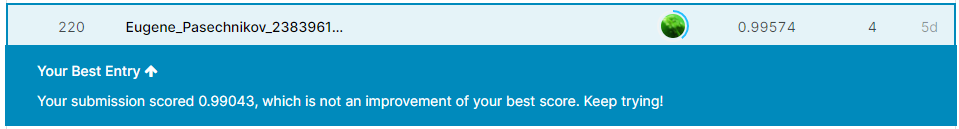

Основна скрипта заимствована из открытых источников. 
Надеюсь принцип - найди решение и сделай его лучше допустим.
Сведения о данных - датасет содержит изображения 42 персонажей сериала Симпсоны.
Наблюдается значительный дисбаланс в отдельных классах 3, 8, 17, 27... 1454 изображения в классе. Средняя 1000 из описания очень "средняя". Для идеального результата классы где мало изображений нужно было дополнить, но времени как обычно нет. Поэтому сначала обрабатываем то что есть, дальше будет ясно, вполне возможно что требуемый score достижим без дополнения датасета. Но учитывая дисбаланс и различные размеры изображений аугментация обязательна, она же 1й ключ к успеху.
2й ключ использовать Transfer Learning, например уже обученную на датасете ImageNet CNN resnet152. Заменить выходной слой и обучить его. 3й ключ оптимизировать границы для learning rate по методу https://arxiv.org/pdf/1506.01186.pdf 
Исследование метода показало, что оптимальные границы learning rate нужно определять на 1й эпохе, и не больше.
Результат score 0.9957

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
# import seaborn as sns
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.PILLOW_VERSION)

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available!  Training on GPU ...')    
else:
    print('CUDA is not available.  Training on CPU ...')

PyTorch Version:  1.9.1
Torchvision Version:  0.10.1
Pillow Version:  8.2.0
CUDA is available!  Training on GPU ...


# Формирование пути к данным

In [2]:
# путь к данным 
train_dir = Path('../input/journey-springfield/train/')
test_dir = Path('../input/journey-springfield/testset/testset/')

### Разделим выборку на train, val и test

In [3]:
class SimpsonTrainValPath():

  def __init__(self, train_dir, test_dir):
    
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):
      
    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, \
                                          stratify=self.train_val_labels)
    
    files_path = {'train': train_files_path, 'val': val_files_path}
    
    return files_path, self.test_path
  
  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))

In [4]:
SimpsonTrainValPath = SimpsonTrainValPath(train_dir, test_dir)
train_path, test_path = SimpsonTrainValPath.get_path()

# Модуль тренировки

In [5]:
def train_model(model, dataloaders, criterion, optimizer, save_best_weights_path, save_last_weights_path, best_acc, num_epochs=2, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    lr_find_lr = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}'.format(epoch))
        print('~' * 80)

        # Установим режим модели
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Режим тренировки
            else:
                model.eval()   # Режим оценки

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обновим значения градиента
                optimizer.zero_grad()

                # forward
                # сохраняем историю, если режим тренировки
                with torch.set_grad_enabled(phase == 'train'):
                    # расчитываем loss
                    # случай для модели inception
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimizer + scheduler если режим тренировки
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
                        lr_find_lr.append(lr_step)

                # статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # loss, acc эпохи
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # сохраняем лучшую модель 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            # сохраняем acc 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        print()
    # распечатаем время тренировки
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим модель с лучшими весами
    model.load_state_dict(best_model_wts)

    history_val = {'loss': val_loss_history, 'acc': val_acc_history}
    history_train = {'loss': train_loss_history, 'acc': train_acc_history}
    
    return model, history_val, history_train, time_elapsed, lr_find_lr, best_acc

# Отключение вычисления градиента

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Модели

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    model_ft = None
    input_size = 0
       
    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft.fc.in_features
        # на последний слой, устанавливаем необходимый выход
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Генерация данных

In [8]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms
      
      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        
        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx]) 
      image = Image.open(img_path)
      image = self.transform(image)
      
      if 'test' in str(self.files_path[0]):
        return image
      else: 
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()
        
        return image, label

# Инициализация модели и подготовка данных

### Настройка модели

In [9]:
# Выбираем модель из определенных в initialize_model
model_name = 'resnet152'
# Дополнительное описание для сохранения модели
fc_layer = 'all-st-SGD-m.9-nest-s-cycle-exp-.00001-.05-g.99994-m.8-.9'

# Количество классов в датасете
num_classes = SimpsonTrainValPath.get_n_classes()

# Размер батча
batch_size = 32

# Количество эпох
num_epochs = 2

# настройка device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# feature_extract = False - обучаем всю модель
# feature_extract = True - обучаем FC
feature_extract = False

# Сохранение весов модели
save_last_weights_path = '/kaggle/working/' + model_name + '-' + fc_layer + '_last_weights.pth'
save_best_weights_path = '/kaggle/working/' + model_name + '-' + fc_layer + '_best_weights.pth'

### Инициализация модели

In [10]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# отправим модель на GPU
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

### Аугментация данных

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomChoice( [ 
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Данные для подачи в сеть

### Dataset

In [12]:
image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}

### Dataloader

In [13]:
dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=4)}

### Визуализируем данные

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

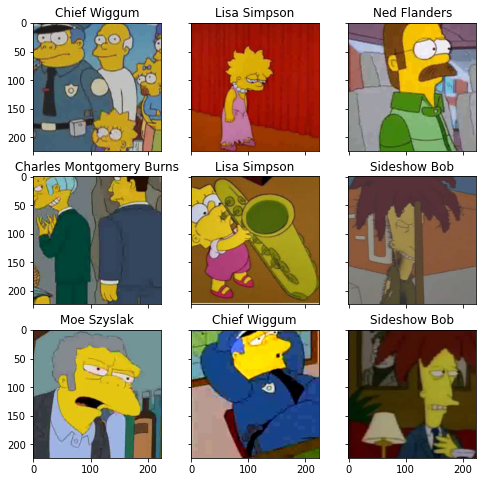

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 4500))
    im_val, label = image_datasets['train'][random_characters]
    # inverse_transform это метод LabelEncoder(), мы закодировали цифрами классы, с помощью inverse_transform из чисел вернём название класса
    # получаем имя персонажа с заглавных букв
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Визуализация обучения

In [16]:
def visualization(train, val, is_loss = True):
  
  if is_loss:
    plt.figure(figsize=(17,10))
    plt.plot(train, label = 'Training loss')
    plt.plot(val, label = 'Val loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
  
  else:
    plt.figure(figsize=(17,10))
    plt.plot(train, label = 'Training acc')
    plt.plot(val, label = 'Val acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

### Параметры для оптимизации

In [17]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            #print("\t",name)

Params to learn:


# Тренировка

Тренировка состоит из двух этапов:
- Найти оптимальный диапазон для lr, чтобы изменять его циклически используя lr_scheduler.CyclicLR из библиотеки Pytorch
- Тренировать модель, используя найденный диапазон

#### Определение оптимального learning rate (lr)

Оптимизацию lr будем проводить используя циклическое изменение его значений в указанном диапазоне. Вначале необходимо определить оптимальные границы диапазона. Для этого проведем тестовый запуск. Выберем step size таким образом, чтобы во время тестового запуска lr линейно возрастал. <br>

После чего построим график accuracy относительно learning rate, на основании графика выберем диапазон значений.

Метод: https://arxiv.org/pdf/1506.01186.pdf

In [18]:
base_lr = 0.00001
max_lr = 0.05
lr_find_epochs = 1

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, nesterov = True)

step_size = lr_find_epochs * len(dataloaders_dict['train'])

scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.99994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

#### Функция для поиска оптимального диапазона lr

In [19]:
def search_lr(lr_find_epochs):
  
  accs = []
  lr_find_lr = []
  acc_sum = 0.0

  for i in range(lr_find_epochs):
    print("epoch {}".format(i))
    for inputs, labels in tqdm_notebook(dataloaders_dict['train']):
      
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      model_ft.train()
      optimizer_ft.zero_grad()
      
      outputs = model_ft(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
      acc_running = torch.sum(preds == labels.data).item()
      acc_sum += torch.sum(preds == labels.data).item()

      loss.backward()
      optimizer_ft.step()
      scheduler.step()
      
      lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
      lr_find_lr.append(lr_step)
      
      accs.append(acc_running)
  accs = np.array(accs) / acc_sum
  
  return lr_find_lr, accs

In [20]:
lr_find_lr, accs = search_lr(lr_find_epochs)

epoch 0


  0%|          | 0/458 [00:00<?, ?it/s]

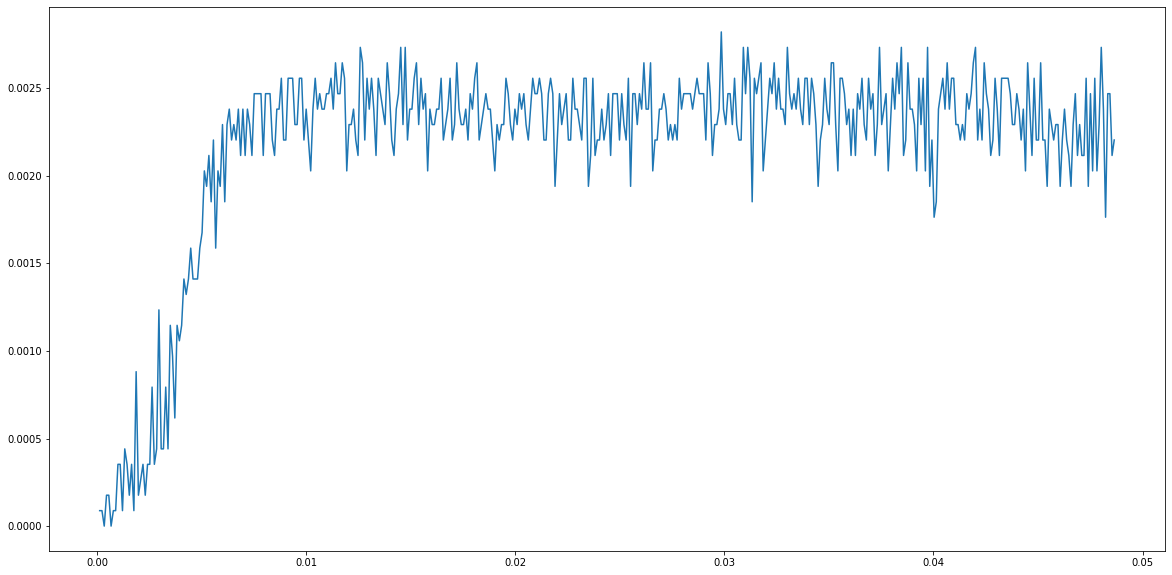

In [21]:
plt.figure(figsize=(20,10))
plt.plot(np.array(lr_find_lr), np.array(accs));

Возьмем диапазон lr, где accuracy возрастает.

#### Тренировка Resnet152

In [22]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

### Определим параметры

In [23]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)            
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass            

Params to learn:


In [24]:
base_lr = 0.0013
max_lr = 0.0024
num_epoch = 7

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(params_to_update, lr=1e-4, momentum=0.9, nesterov = True)
step_size = 2 * math.ceil(len(dataloaders_dict['train']) / batch_size)
scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [25]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
lr_cycle = []
best_acc = .0

In [26]:
for i in range(num_epoch):
  
    # каждый раз будем подавать сети новые аугментированные данные
    image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}

    dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=False, num_workers=4),
                          'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)}

    model, history_val, history_train, time_elapsed, lr_find_lr, best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, save_best_weights_path, save_last_weights_path, best_acc = best_acc, num_epochs=1, is_inception=(model_name=="inception"))

    val_loss += history_val['loss']
    val_acc += history_val['acc']
    train_loss += history_train['loss']
    train_acc += history_train['acc']
    lr_cycle += lr_find_lr

Epoch 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 1.0229 Acc: 0.7688


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.2891 Acc: 0.9373

Training complete in 3m 36s
Best val Acc: 0.937261
Epoch 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.2096 Acc: 0.9509


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.1606 Acc: 0.9627

Training complete in 3m 32s
Best val Acc: 0.962739
Epoch 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0889 Acc: 0.9812


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.1292 Acc: 0.9720

Training complete in 3m 32s
Best val Acc: 0.971975
Epoch 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0499 Acc: 0.9906


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.1101 Acc: 0.9756

Training complete in 3m 32s
Best val Acc: 0.975637
Epoch 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0295 Acc: 0.9950


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.1108 Acc: 0.9760

Training complete in 3m 32s
Best val Acc: 0.975955
Epoch 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0182 Acc: 0.9972


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.1107 Acc: 0.9777

Training complete in 3m 32s
Best val Acc: 0.977707
Epoch 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/458 [00:00<?, ?it/s]

train Loss: 0.0142 Acc: 0.9978


  0%|          | 0/197 [00:00<?, ?it/s]

val Loss: 0.1036 Acc: 0.9779

Training complete in 3m 32s
Best val Acc: 0.977866


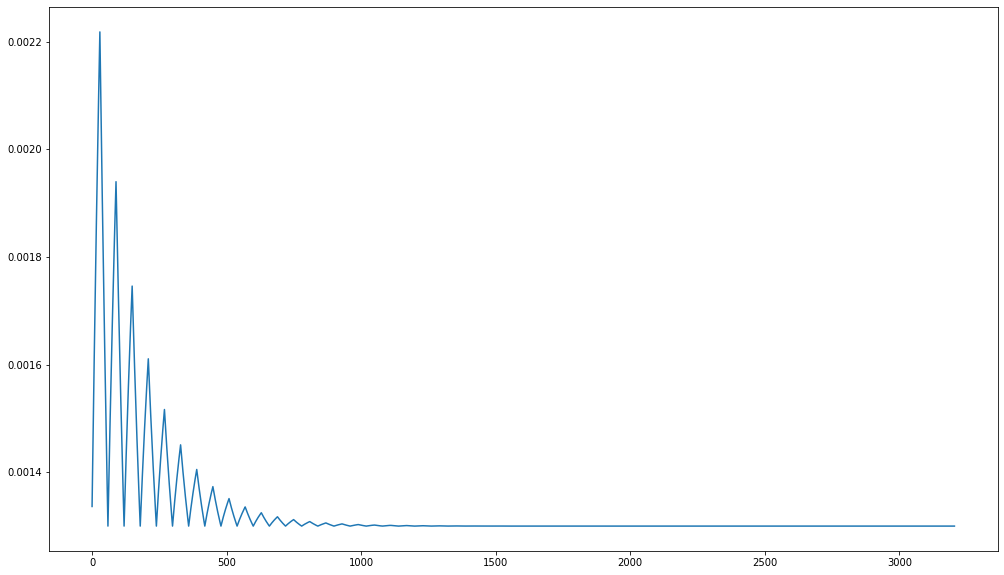

In [27]:
plt.figure(figsize=(17,10))
plt.plot(lr_cycle);

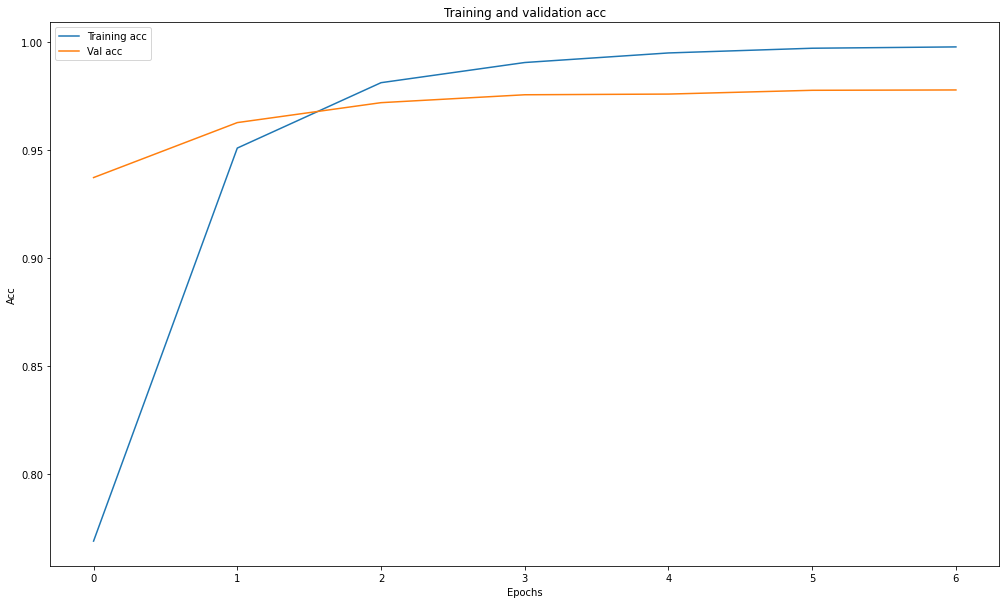

In [28]:
visualization(train_acc, val_acc, is_loss = False)

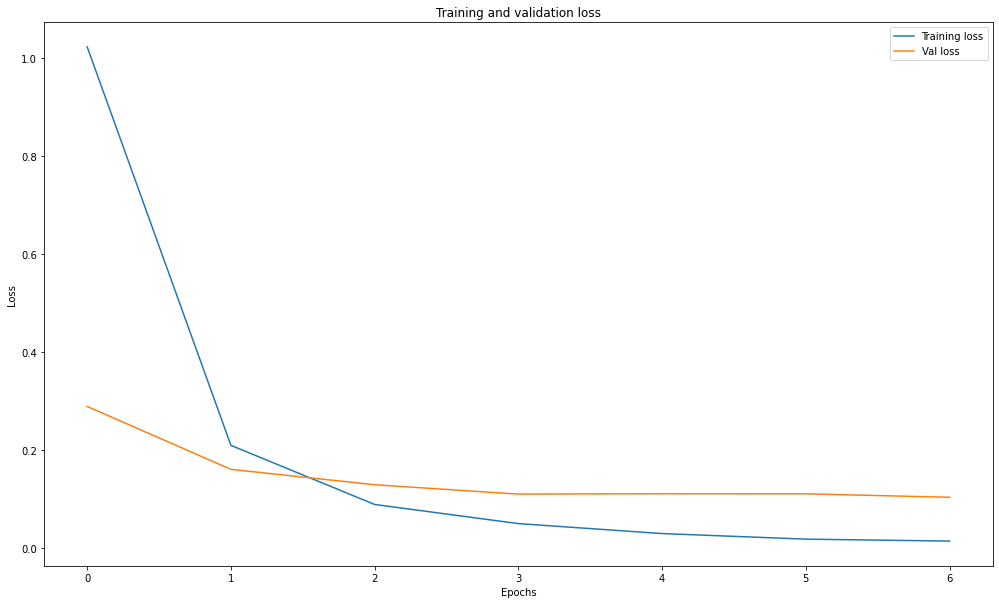

In [29]:
visualization(train_loss, val_loss, is_loss = True)

# Функция предсказания

In [30]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

### Предсказание для одного изображения

In [31]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():        
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

# Определим метрику из задания f1-score для валидационной выборки

для наглядности сделаем визуализацию classification_report которая содержит в том числе и f1-score

In [32]:
def f1_score_view():
    # вытащим настоящие лейблы!
    actual = [image_datasets['val'][i][1] for i in range( len(image_datasets['val']) ) ]
    
    # вытащим картинки, чтобы их подать в даталоадер, а потом классификатору
    image = [image_datasets['val'][i][0] for i in range( len(image_datasets['val']) ) ]
    
    # подготовим даталоадер
    img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # вытащим предсказанные лейблы
    probs = predict(model_ft, img_conf_dataloader)
    preds = np.argmax(probs, axis=1)
    lbl_enc = pickle.load(open("label_encoder.pkl", 'rb'))
    classes = lbl_enc.classes_
    print(classification_report(actual, preds,target_names = classes))

In [33]:
f1_score_view()

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.99      0.99      0.99       274
           agnes_skinner       1.00      0.77      0.87        13
  apu_nahasapeemapetilon       0.99      0.99      0.99       187
           barney_gumble       0.96      0.84      0.90        32
            bart_simpson       0.98      0.99      0.99       403
            carl_carlson       1.00      1.00      1.00        29
charles_montgomery_burns       0.99      0.97      0.98       358
            chief_wiggum       0.96      0.98      0.97       296
         cletus_spuckler       1.00      0.93      0.96        14
          comic_book_guy       0.99      0.98      0.98       141
               disco_stu       0.00      0.00      0.00         2
          edna_krabappel       0.96      0.99      0.97       137
                fat_tony       0.88      0.88      0.88         8
                     gil       0.89      1.00      0.94         8
    groun

# Визуализируем точность предсказания модели

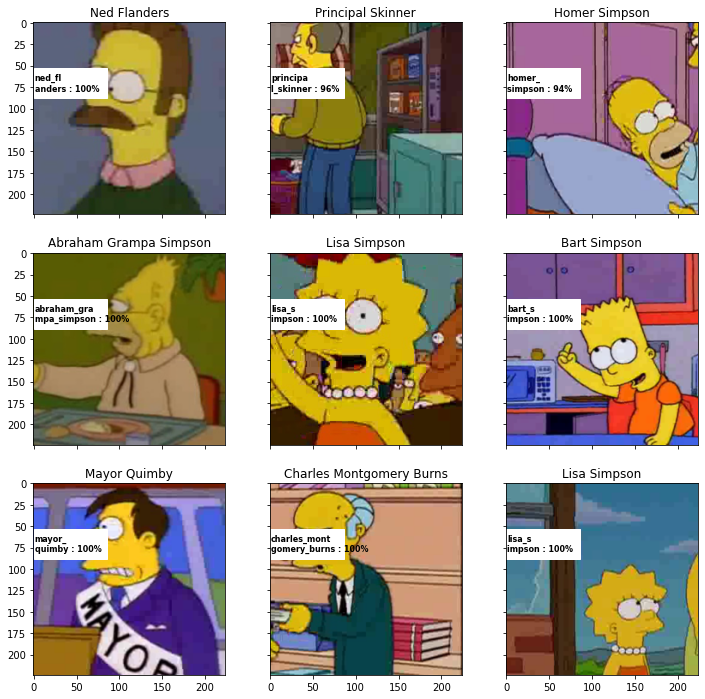

In [34]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = image_datasets['val'][random_characters]
    # inverse_transform это метод LabelEncoder(), мы закодировали цифрами классы, с помощью inverse_transform из чисел вернём название класса
    # получаем имя персонажа с заглавных букв
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)

    # добавим область на которой будем выводить вероятность        
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    # получаем вероятность
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Submit на Kaggle

**Загрузим и подготовим тестовый датасет**

In [35]:
image_datasets_test = SimpsonsDataset(test_path, data_transforms['val'])
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [36]:
# вытащим предсказанные лейблы
probs = predict(model_ft, dataloader_test)
# загрузим наш инкодер
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
# пропишем классы из инкодера
preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1))

**создадим и запишем файл submission**

In [37]:
test_filenames = [path.name for path in image_datasets_test.files_path]
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [38]:
submit.to_csv('simspsons6.csv', index=False)